**Gordon Doore Ghailan Fadah**

Fall 2023

CS 343: Neural Networks

Project 2: Multi-layer Perceptrons

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# for obtaining the STL-dataset
import load_stl10_dataset

# for preprocessing dataset
import preprocess_data

# Set the color style so that Professor Layton can see your plots
plt.show()
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Turn off scientific notation when printing
np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

/var/folders/nn/7dg3frxj7110d9z8g5flwtj80000gn/T/ipykernel_45539/716085586.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
/var/folders/nn/7dg3frxj7110d9z8g5flwtj80000gn/T/ipykernel_45539/716085586.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])


## Task 2: Implement single layer network to test softmax activation and cross-entropy loss

You will first implement and test out the softmax activation and cross-entropy loss in a single layer net before embedding it in a more complex multi-layer network.

### 2a. Load in preprocessed STL-10 data

Use your automated preprocessing function to load in the STL-10 data in the following split:
- 3000 training samples
- 750 test samples
- 1000 validation samples
- 250 samples for development

In [2]:
stl_labels = np.load("numpy/labels.npy")
stl_imgs = np.load("numpy/images.npy")
stl_imgs_pp, stl_labels_pp = preprocess_data.preprocess_stl(stl_imgs, stl_labels)

x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.create_splits(stl_imgs_pp, stl_labels_pp) #

### 2b. Implement the following functions

In `softmax_layer.py`, implement the following methods in the base class `SoftmaxLayer`:

- `fit`
- `net_in`
- `predict`
- `one_hot`
- `accuracy`
- `activation` (softmax) $f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^C e^{x_j}}$ where $x_i$ are the "net in" values and there are $C$ output neurons (one per input class). $f(x_i)$ is the activation values of each output neuron $i$. Since this is softmax, it is the probability that a given input belongs to the class $i$ coded by the output neuron.
- `loss` (cross-entropy) $L(x_m) = -\frac{1}{B}\sum_{b=1}^B{Log \left (\frac{e^{x_m}}{\sum_{n=1}^C e^{x_n}}\right )}$. $m$ is the correct class for the $b^{th}$ input. $x_m$ is the output neuron activation for the correct class, $x_n$ is the output neuron activation for all of the classes (in the sum). The batch size is $B$, so the loss is averaged over each mini-batch of inputs. The expression in the $Log$ is just the softmax.
- `gradient` (for softmax/cross-entropy)

You're welcome to work in any order, but I recommend starting with `fit` because as you work though it, you should recognize why we need most of the other methods. You can finish `fit` or branch off as you need the other methods.

### 2c. Test key functions

In [3]:
from softmax_layer import SoftmaxLayer

In [4]:
# Let's generate some small Gaussian weights equal to the length of an image feature vector
np.random.seed(0)
randWts = np.random.normal(loc=0, scale=0.01, size=(x_dev.shape[1], 10))
b = 1
softmaxNet = SoftmaxLayer(-1)

# Fake data for consistent debugging
test_imgs = np.random.random(size=(15, x_dev.shape[1])) - 0.5
test_labels = np.random.randint(low=0, high=6, size=(15,))

#### Test the `onehot` function

In [5]:
y_test1 = np.array([1, 2, 2, 0, 1, 3])
c_test = 4
y_one_hot = softmaxNet.one_hot(y_test1, c_test)
print(f'Your one hot vectors:\n{y_one_hot}')

Your one hot vectors:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


Your one hot vectors should look like:

    [[0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 1. 0.]
     [1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 0. 1.]]

#### Test the `loss`,  `net_in`, softmax `activation` functions

In [19]:
lossNoReg, lossReg = softmaxNet.test_loss(randWts, b, test_imgs, test_labels)
print(f'The loss (without regularization) is {lossNoReg:.2f} and it should approx be 2.37')
print(f'The loss (with 0.5 regularization) is {lossReg:.2f} and it should approx be 3.13')

(15, 3072) (3072, 10)
net in shape=(15, 10), min=0.6770080064951228, max=1.4469478863251897
Should be
net in shape=(15, 10), min=0.6770080064951229, max=1.4469478863251897

net act shape=(15, 10), min=0.0688478818744139, max=0.1502037762718014
Should be
net act shape=(15, 10), min=0.0688478818744139, max=0.15020377627180137

The loss (without regularization) is 2.37 and it should approx be 2.37
The loss (with 0.5 regularization) is 3.13 and it should approx be 3.13


#### Test the `gradient` function

In [20]:
grad_wts, grad_b = softmaxNet.test_gradient(randWts, b, test_imgs, test_labels, 10)

print(f'1st few Wt gradient values are {grad_wts[:4,0]}\nand should be                  [-0.012  0.003  0.025 -0.023] ')
print(f'1st few Wt bias values are {grad_b[:4]}\nand should be              [-0.101 -0.099 -0.037  0.101]')


(15, 3072) (3072, 10)
net in: (15, 10), 0.6770080064951228, 1.4469478863251897
net in 1st few values of 1st input are:
[0.864 0.927 0.874 1.159 1.392]
and should be
[0.864 0.927 0.874 1.159 1.392]
net act 1st few values of 1st input are:
[0.078 0.083 0.079 0.105 0.132]
and should be
[0.078 0.083 0.079 0.105 0.132]
y one hot: (15, 10), sum is 15.0.
You should know what the sum should be :)
1st few Wt gradient values are [-0.012  0.003  0.025 -0.023]
and should be                  [-0.012  0.003  0.025 -0.023] 
1st few Wt bias values are [-0.101 -0.099 -0.037  0.101]
and should be              [-0.101 -0.099 -0.037  0.101]


#### Test `fit` function

In [37]:
np.random.seed(0)
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250)


epoch: 0 ------ loss: 2.511479737745911
epoch: 100 ------ loss: 0.41853117240475574
epoch: 200 ------ loss: 0.17434664878363038
epoch: 300 ------ loss: 0.12102787681170506
epoch: 400 ------ loss: 0.08469211714258082
epoch: 500 ------ loss: 0.06334555934215903
epoch: 600 ------ loss: 0.050798452926856315


Given the random mini-batch sampling process, you may get different specific numbers, but the loss should generally decrease over iterations. You should get something like this:

```
Starting to train network...There will be 600 epochs and 600 iterations total, 1 iter/epoch.
  Completed iter 0/600. Training loss: 2.46.
  Completed iter 100/600. Training loss: 2.16.
  Completed iter 200/600. Training loss: 2.02.
  Completed iter 300/600. Training loss: 1.91.
  Completed iter 400/600. Training loss: 1.92.
  Completed iter 500/600. Training loss: 1.80.
Finished training!
```

##### Plot the loss

It should look noisy, but decrease on average.

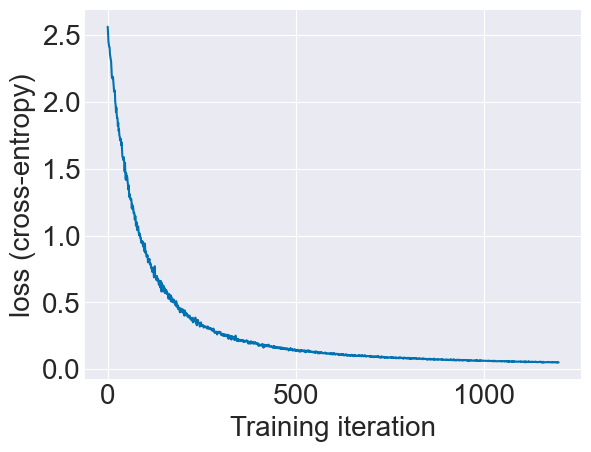

In [38]:
def plot_cross_entropy_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel('Training iteration')
    plt.ylabel('loss (cross-entropy)')
    plt.show()
    
plot_cross_entropy_loss(loss_history)

### 2d. Questions

**Question 1.** What do you think the decrease in loss over the epochs tells us about the state of the training process? How is current training going? What's the future potential like?

**Question 2.** Below, write code to test regularization with training: check to make sure that the loss starts at ~154 for `reg=100`. Once you get this working, play around with the regularization parameter. You can drastically change the magnitude, but it should always remain nonnegative. How does regularization affect the training loss and **why**?

**Question 3.** Play around with the batch size parameter. How does this affect the training loss and **why**? (*Think about the error gradient and how the weights change*)

**Answer 1:**  It looks like there could be a little bit more reduction in loss, but we are pretty close to as good as we are going to get here.

### Changing Regularization

#### Reg = 100

epoch: 0 ------ loss: 154.19321858732397
epoch: 100 ------ loss: 154.19971988622345
epoch: 200 ------ loss: 157.09561836649618
epoch: 300 ------ loss: 161.0004702269611
epoch: 400 ------ loss: 166.08811455516783
epoch: 500 ------ loss: 172.69547656917683
epoch: 600 ------ loss: 181.16169820994185


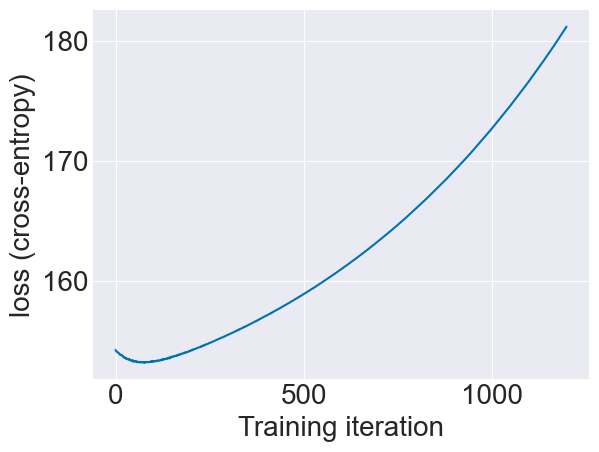

In [39]:
np.random.seed(0)

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = 100)

plot_cross_entropy_loss(loss_history)



#### Reg = 30

epoch: 0 ------ loss: 48.01591792089145
epoch: 100 ------ loss: 46.38796673588381
epoch: 200 ------ loss: 46.6097050207592
epoch: 300 ------ loss: 46.926178005805774
epoch: 400 ------ loss: 47.22128560745177
epoch: 500 ------ loss: 47.521582378989336
epoch: 600 ------ loss: 47.832238457637615


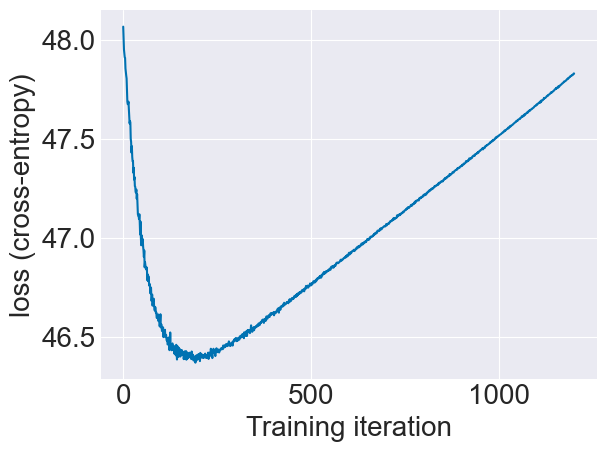

In [40]:
np.random.seed(0)

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = 30)

plot_cross_entropy_loss(loss_history)


#### Reg = 10

epoch: 0 ------ loss: 17.679617930859976
epoch: 100 ------ loss: 15.73598224834454
epoch: 200 ------ loss: 15.632711171263455
epoch: 300 ------ loss: 15.679175624088515
epoch: 400 ------ loss: 15.720498397466969
epoch: 500 ------ loss: 15.763944874754912
epoch: 600 ------ loss: 15.80741342437479


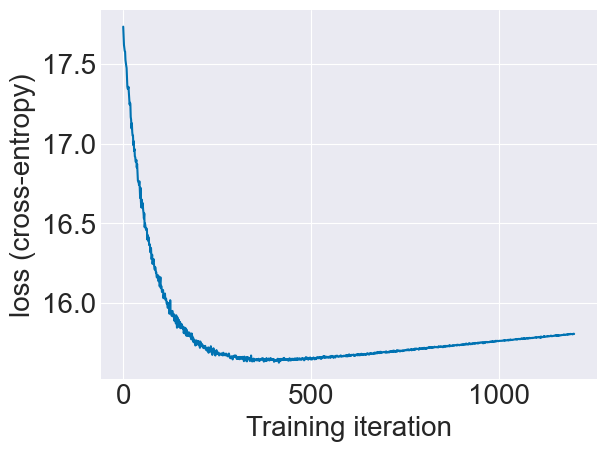

In [41]:
np.random.seed(0)

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = 10)

plot_cross_entropy_loss(loss_history)

#### Reg = 3

epoch: 0 ------ loss: 7.0619203721222625
epoch: 100 ------ loss: 5.013482374792257
epoch: 200 ------ loss: 4.811011574709404
epoch: 300 ------ loss: 4.786769623639268
epoch: 400 ------ loss: 4.7725671379685926
epoch: 500 ------ loss: 4.769181663411015
epoch: 600 ------ loss: 4.771664830591312


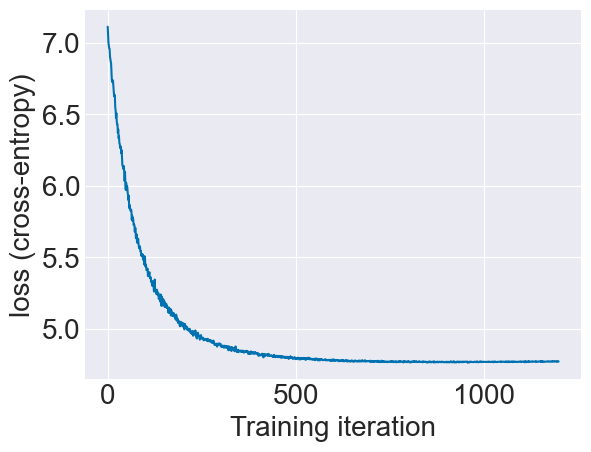

In [42]:
np.random.seed(0)

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = 3)

plot_cross_entropy_loss(loss_history)

#### Reg = 0.5

epoch: 0 ------ loss: 3.2698864611746035
epoch: 100 ------ loss: 1.184346028285199
epoch: 200 ------ loss: 0.9471003095682705
epoch: 300 ------ loss: 0.8986100520218017
epoch: 400 ------ loss: 0.8659411163555488
epoch: 500 ------ loss: 0.8475613679651587
epoch: 600 ------ loss: 0.8374881669242745


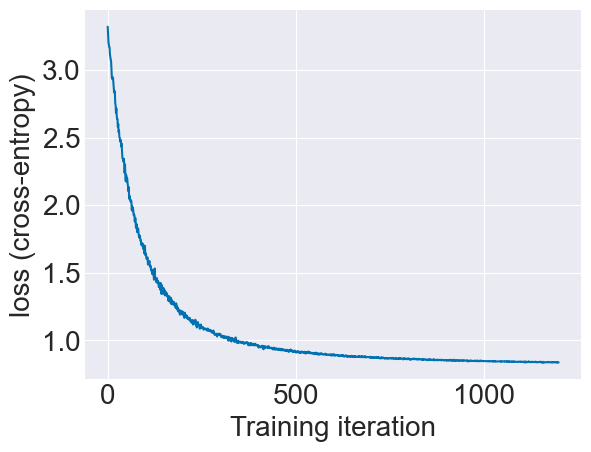

In [43]:
np.random.seed(0)

softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250, reg = 0.5)

plot_cross_entropy_loss(loss_history)

**Answer 2:**  We see that with regularization, for large values, the model cannot train properly.  This is because we are essentially asking our update rule to something impossible.  For large values of reg, we must penalize large weights more, and thus increase our loss on a scale beyond a reasonable loss value.  Having higher weight values can be associated with overtraining, but the model needs to be able to distinguish between features using larger weights, and larger than reasonable regularization values make this more difficult since it scales our loss according to even the smallest differentiation.

### Changing (mini) Batch Size

#### Base Case: mini_batch_size = 250

epoch: 0 ------ loss: 2.4205868158278605
epoch: 100 ------ loss: 0.4089672606378477
epoch: 200 ------ loss: 0.18494567013470484
epoch: 300 ------ loss: 0.1179050194051085
epoch: 400 ------ loss: 0.0816501420542137
epoch: 500 ------ loss: 0.060779197773290536
epoch: 600 ------ loss: 0.04882536365248633


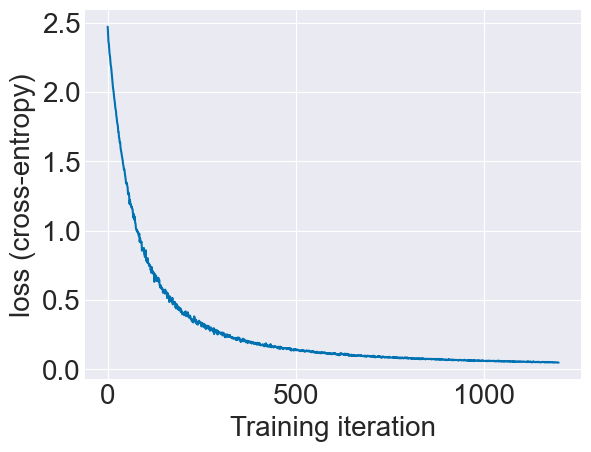

In [45]:
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=250)

plot_cross_entropy_loss(loss_history)

#### mini_batch_size = 150

epoch: 0 ------ loss: 2.4595942769666386
epoch: 100 ------ loss: 0.3038443677428789
epoch: 200 ------ loss: 0.1151472076794228
epoch: 300 ------ loss: 0.07261055527135996
epoch: 400 ------ loss: 0.05279543937659726
epoch: 500 ------ loss: 0.038462022888899716
epoch: 600 ------ loss: 0.03431908774332665


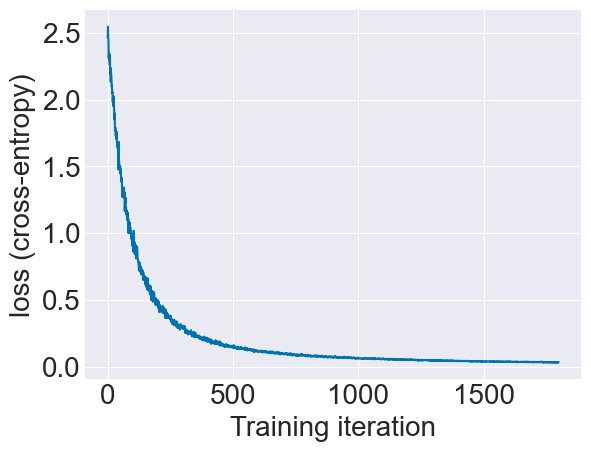

In [46]:
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=150)

plot_cross_entropy_loss(loss_history)

#### mini_batch_size = 50

epoch: 0 ------ loss: 1.9599124800169312
epoch: 100 ------ loss: 0.06498723138440543
epoch: 200 ------ loss: 0.030237172306175692
epoch: 300 ------ loss: 0.01739025602663857
epoch: 400 ------ loss: 0.013826984701098763
epoch: 500 ------ loss: 0.010981849951164024
epoch: 600 ------ loss: 0.008733408558907661


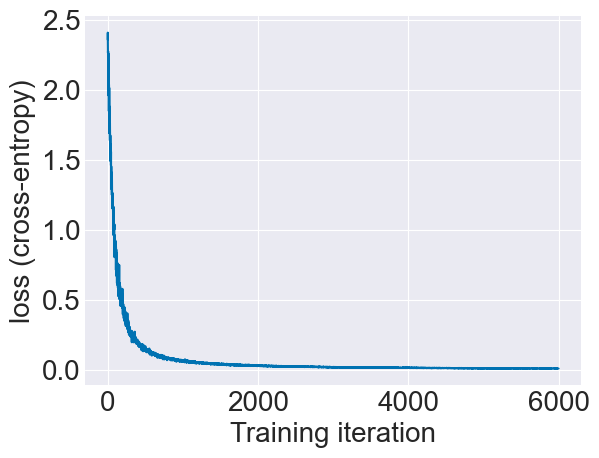

In [47]:
softmaxNet = SoftmaxLayer(10)
loss_history = softmaxNet.fit(x_dev, y_dev, n_epochs=600, mini_batch_sz=50)

plot_cross_entropy_loss(loss_history)

**Answer 3:**  We can see that as mini-batch size is reduced, our loss goes down faster.  The reason for this is that we are updating weights after each batch is passed throgh the network.  If the batches represent the data as a whole well, the network will learn faster because it will get more weight updates per epoch.

### 2e. Train and optimize STL-10 dataset performance

As you've surely noticed, hyperparameters can drastically affect learning! 


Implement a grid search for the best **combinations** of hyperparameters

- learning rate,
- regularization
- batch size 

Fix the training duration to `75` epochs.

The grid search process should:

1. Fit the model with specific values of hyperparameters that we're testing (using the training set).
2. Compute the accuracy on the **training set**. 
3. Compute the accuracy on the **validation set.** 
4. Print out and record the best parameter combination as you go (that *improves* the **validation set accuracy**).
5. Wipe the weights clean (reinitialize them) every time you try new parameters. It's easiest just to create a new net object on each run.

#### Suggestions

This can take quite a bit of simulation time! Here are some tips:
- I suggest using a coarse-to-fine search strategy. Try varying hyperparameters over many orders of magnitude, then follow up with a 2nd search that "zooms in" around the hyperparameters that gave you the best results from the first search, as determined by your print outs. You can be informal about this and hard-code the coarse and fine hyperparameter choices. Abort searches prematurely if you feel there aren't productive (no reason to wait!). This can take however long or short that you want to dedicate. Remember, you are printing out the best parameter values on each run, so you can always just proceed with those.
- You should be able to achieve ~30% accuracy without too much effort (10% is chance performance).
- High learning rates don't really make sense. You'll know if your value is "high" if numpy complains about numerical issues.
- Your mini-batch sizes should be `<= N` and `>= 1`.
- Time single network runs with a few different batch sizes you plan on trying in your big search. This will help you figure out a ballpark estimate how long grid search will take (*you can decide whether to go eat dinner, run it overnight, etc.*). If it will take an unreasonable amount of time, reduce the number of parameters you try in one search.
- Think about whether you need *3 nested loops* or *a sequence of single loops*.
- Turn off print outs from `fit` (adjust `verbose` argument) and only print out things related to your search.
- Feel free to try a search with more than 75 training epochs for potentially better accuracy, but note that the search will take longer to complete.

**Important note:** I am not grading based on your performance numbers or the number of hours your computer spends searching. I want to see that you successfully implemented the grid search to find progressively better hyperparameters on STL-10 and use the outcome to inform your ultimate training session that you use to evaluate predictions on the test set. *Getting full credit here does not require you spending hours of searching!*

In [10]:
list_learing_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10]
list_reg = [0.0001, 0.001, 0.01, 0.1, 1, 10]
list_batch = [50, 100, 150, 300, 600, 1200]
best_accuracy_train = 0
best_accuracy_val = 0 
for rate in list_learing_rate:
    for reg in list_reg:
        for batch in list_batch:
            soft_mx = SoftmaxLayer(10)
            soft_mx.fit(x_train, y_train, 75, rate, batch, reg, 0)
            y_pred_val = soft_mx.predict(x_val)
            y_pred_train = soft_mx.predict(x_train) 
            acc_val = soft_mx.accuracy(y_val, y_pred_val)
            acc_train = soft_mx.accuracy(y_train, y_pred_train)
            if acc_val >= best_accuracy_val:
                    best_accuracy_val = acc_val
                    print("train accuarcy:", acc_train)
                    print("val accuracy:", best_accuracy_val)
                    print("batch_size:", batch, "reg:", reg, "rate:", rate)
                
            
            

train accuarcy: 0.14885714285714285
val accuracy: 0.134
batch_size: 50 reg: 0.0001 rate: 0.0001
train accuarcy: 0.138
val accuracy: 0.138
batch_size: 150 reg: 0.0001 rate: 0.0001
train accuarcy: 0.15971428571428573
val accuracy: 0.15
batch_size: 600 reg: 0.0001 rate: 0.0001
train accuarcy: 0.1482857142857143
val accuracy: 0.154
batch_size: 1200 reg: 0.01 rate: 0.0001
train accuarcy: 0.15028571428571427
val accuracy: 0.154
batch_size: 100 reg: 0.1 rate: 0.0001
train accuarcy: 0.15285714285714286
val accuracy: 0.154
batch_size: 150 reg: 1 rate: 0.0001
train accuarcy: 0.144
val accuracy: 0.156
batch_size: 50 reg: 0.01 rate: 0.001


/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:252: RuntimeWarning: divide by zero encountered in log
  loss = -(1/y.size)*np.sum(np.log(corrects))+(1/2)*reg*np.sum(self.wts**2)
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:252: RuntimeWarning: overflow encountered in square
  loss = -(1/y.size)*np.sum(np.log(corrects))+(1/2)*reg*np.sum(self.wts**2)
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:282: RuntimeWarning: overflow encountered in square
  return  (1/mini_batch_size)*(errors.T @ features).T+reg*(self.wts**2), ((1/mini_batch_size)*np.sum(errors, axis = 0))
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:219: RuntimeWarning: invalid value encountered in subtract
  adj_net = net_in - z_max


train accuarcy: 0.14885714285714285
val accuracy: 0.156
batch_size: 50 reg: 0.1 rate: 0.01
train accuarcy: 0.14457142857142857
val accuracy: 0.158
batch_size: 600 reg: 0.1 rate: 0.01


/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:58: RuntimeWarning: invalid value encountered in matmul
  net_in = features @ self.wts + self.b
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:282: RuntimeWarning: overflow encountered in multiply
  return  (1/mini_batch_size)*(errors.T @ features).T+reg*(self.wts**2), ((1/mini_batch_size)*np.sum(errors, axis = 0))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:167: RuntimeWarning: overflow encountered in multiply
  w_step = lr*gradient_w
/Users/ghailanfadah/Desktop/CH343/project 2/softmax_layer.py:58: RuntimeWarning: overflow encountered in matmul
  net_in = features @ self.wts + self.b


### 2f. Evaluate best model on test set

**Question 4:** Now that you have "good" parameter values recorded, train a new model with the best learning rate, regularization strength, and batch size values in the cell below. What accuracy do you get on the **test set**? How does this compare to chance performance?

*Recall: The test set should NOT be used in your grid search. It should only be processed once AFTER you conclude your grid search.*

**Answer 4:**

### 2g. Visualize learned weights

Run the following code that plots the network weights going to each output neuron. If all goes well, you should see something really cool! Include the plot in your submitted project to show me what you got!

**Note:** the quality of your visualizations will depend on:
- The quality of the hyperparameters that you got via grid search.
- How many epochs that you trained the network before plotting the weights

One extension idea: is to find the combination of the above that result in the best visualizations.

In [ ]:
# Load in the class names
classes = np.loadtxt(os.path.join('data', 'stl10_binary', 'class_names.txt'), dtype=str)

# We don't care about the bias wt
wts = bestNet.wts
# Reshape the wt vectors into spatial 'image' configurations to visualization
wts = wts.reshape(32, 32, 3, 10)

# Make a large new empty figure/plot
plt.figure(figsize=(10, 4))

# Loop through each output neuron
for i in range(10):
  # Make a 2x5 grid of images
  plt.subplot(2, 5, i+1)
  
  # Rescale the weights to be between 0 and 255
  currImg = 255.0 * (wts[:, :, :, i].squeeze() - np.min(wts)) / (np.max(wts) - np.min(wts))
  
  plt.imshow(currImg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.subplots_adjust(wspace=0.35, hspace=0)
plt.show()